#Dynamic connection layer

In [ ]:
import tensorflow as tf

class DynamicConnectionLayer(tf.keras.layers.Layer):
  def __init__(self, num_heads, depth, temperature,**kwargs):
    super().__init__(**kwargs)
    self.num_heads = num_heads
    self.depth = depth
    self.temperature = temperature

  def build(self, input_shape):
    atomics_shape, connection_shape = input_shape

    batch_1, self.num_atoms, features_dim = atomics_shape
    batch_2, num_atoms_2, num_atoms_3 = connection_shape

    assert self.num_atoms == num_atoms_2, 'number of atoms in two inputs must be equal'
    assert num_atoms_2 == num_atoms_3, 'connection input must be square matrix'

    self.query_kernel = self.add_weight(shape=(features_dim, self.num_heads*self.depth), initializer='glorot_uniform', trainable=True, name='query_kernel')
    self.key_kernel = self.add_weight(shape=(features_dim, self.num_heads*self.depth), initializer='glorot_uniform', trainable=True, name='key_kernel')
    self.std_kernel = self.add_weight(shape=(features_dim, self.num_heads), initializer='glorot_uniform', trainable=True, name='std_kernel')

    self.query_bias = self.add_weight(shape=(self.num_heads*self.depth,), initializer='zeros', trainable=True, name='query_bias')
    self.key_bias = self.add_weight(shape=(self.num_heads*self.depth,), initializer='zeros', trainable=True, name='key_bias')
    self.std_bias = self.add_weight(shape=(self.num_heads,), initializer='zeros', trainable=True, name='std_bias')

    self.connection_kernel = self.add_weight(shape=(self.num_heads, 4*self.num_heads), initializer='glorot_uniform', trainable=True, name='conncetion_kernel')
    self.connection_bias = self.add_weight(shape=(4*self.num_heads,), initializer='zeros', trainable=True, name='connection_bias')
    self.connection_heads_weight = self.add_weight(shape=(4*self.num_heads, self.num_heads), initializer='glorot_uniform', trainable=True, name='connection_heads_weight')

    super().build(input_shape)


  def call(self, inputs):
    atomic_input, connection_input = inputs

    connection_input = tf.expand_dims(connection_input, axis=1)
    connection_input = tf.tile(connection_input, [1, self.num_heads, 1, 1])

    query = tf.matmul(atomic_input, self.query_kernel) + self.query_bias
    key = tf.matmul(atomic_input, self.key_kernel) + self.key_bias
    std = tf.matmul(atomic_input, self.std_kernel) + self.std_bias

    query = tf.reshape(query, (-1, self.num_atoms, self.num_heads, self.depth))
    key = tf.reshape(key, (-1, self.num_atoms, self.num_heads, self.depth))
    std = tf.reshape(std, (-1, self.num_atoms, self.num_heads, 1))

    query = tf.transpose(query, perm=[0, 2, 1, 3])
    key = tf.transpose(key, perm=[0, 2, 3, 1])
    std = tf.transpose(std, perm=[0, 2, 1, 3])

    attention_weights = tf.matmul(query, key) / tf.math.sqrt(tf.cast(self.depth, tf.float32))

    std = tf.nn.softplus(std)

    connection_gaussian_noise = tf.random.normal(shape=tf.shape(attention_weights), mean=attention_weights, stddev=std)
    connection_gaussian_noise = connection_gaussian_noise * self.temperature
    connection_gaussian_noise = (connection_gaussian_noise + tf.transpose(attention_weights, perm=[0, 1, 3, 2]))/ 2.0

    atoms_connection_weight = connection_input + connection_gaussian_noise

    atoms_connection_weight = tf.transpose(atoms_connection_weight, perm=[0, 2, 3, 1])
    updated_connection_weight = tf.matmul(atoms_connection_weight, self.connection_kernel) + self.connection_bias
    updated_connection_weight = tf.nn.tanh(updated_connection_weight)
    updated_connection_weight = tf.matmul(updated_connection_weight, self.connection_heads_weight)
    updated_connection = updated_connection_weight * atoms_connection_weight
    updated_connection = tf.reduce_sum(updated_connection, axis=-1)/ tf.math.sqrt(tf.cast(self.num_heads, tf.float32))
    return updated_connection

# Standard GraphConvolutionLayer

In [ ]:
import tensorflow as tf

class GraphConvolutionLayer(tf.keras.layers.Layer):
  def __init__(self, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
               bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
               kernel_constraint=None, bias_constraint=None, **kwargs):
    super().__init__(**kwargs)
    self.activation = activation
    self.use_bias=use_bias
    self.kernel_initializer = kernel_initializer
    self.kernel_regularizer = kernel_regularizer
    self.kernel_constraint = kernel_constraint
    self.bias_initializer = bias_initializer
    self.bias_regularizer = bias_regularizer
    self.bias_constraint = bias_constraint


  def normalize_adjacency(self, adjacency):
    degree = tf.reduce_sum(adjacency, axis=-1)

    degree += 1e-7
    degree = tf.pow(degree, -0.5)
    degree = tf.linalg.diag(degree)
    return tf.matmul(degree, tf.matmul(adjacency, degree))


  def build(self, input_shapes):
    feature_shape, _ = input_shapes

    self.feature_transform = tf.keras.layers.Dense(units=feature_shape[-1],activation=self.activation,use_bias=self.use_bias,
                                                   kernel_initializer=self.kernel_initializer, kernel_regularizer=self.kernel_regularizer,
                                                   kernel_constraint=self.kernel_constraint, bias_initializer=self.bias_initializer,
                                                   bias_regularizer=self.bias_regularizer, bias_constraint=self.bias_constraint)
    super().build(input_shapes)

  def call(self, inputs):
    node_feature, adjacency_matrix = inputs

    adjacency_matrix = self.normalize_adjacency(adjacency=adjacency_matrix)

    fusion_feature = tf.matmul(adjacency_matrix, node_feature)
    fusion_feature = self.feature_transform(fusion_feature)
    return fusion_feature


  def compute_output_shape(self, input_shape):
    return input_shape[0]

  def get_config(self):
    base_config = super().get_config()
    config = self.feature_transform.get_config()
    return {**base_config, **config}

# chemical bond prediction test (model)

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

class DCLTestModel(tf.keras.Model):
  def __init__(self, atom_types, num_heads, depth, layers=1, **kwargs):
    super().__init__(**kwargs)
    self.dcl_block = [DynamicConnectionLayer(num_heads=num_heads, depth=depth, temperature=1.0, name='dcl') for _ in range(layers)]
    self.dense = tf.keras.layers.Dense(5, kernel_initializer='glorot_uniform')
    self.embedding = tf.keras.layers.Embedding(atom_types+1, num_heads*depth, embeddings_initializer='random_normal', name='atom_embedding', trainable=False)

  def call(self, inputs):
    atoms, distance = inputs
    atoms = self.embedding(atoms)
    updated_connection = distance
    for dcl in self.dcl_block:
      updated_connection = dcl([atoms, updated_connection])
    bond_probility = self.dense(tf.expand_dims(updated_connection, axis=-1))
    bond_probility = tf.nn.softmax(bond_probility, axis=-1)
    return bond_probility

  def get_update_connection(self, inputs):
    atoms, distance = inputs
    updated_connection = distance
    atoms = self.embedding(atoms)
    for dcl in self.dcl_block:
      updated_connection = dcl([atoms, updated_connection])
    return updated_connection


class ControlModel(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.dense = tf.keras.layers.Dense(5, kernel_initializer='glorot_uniform')

  def call(self, inputs):
    distance = inputs
    bond_porbility = self.dense(tf.expand_dims(distance, axis=-1))
    bond_porbility = tf.nn.softmax(bond_porbility, axis=-1)

    return bond_porbility


def weight_valence_bond_loss(weight):

  def loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
    log_y_pred = tf.math.log(y_pred)
    cross_entropy = tf.reduce_sum(weight * (-y_true * log_y_pred), axis=-1)
    return cross_entropy

  return loss


def normalize_matrix(matrix, epsilon=1e-6):
  mean = np.mean(matrix, axis=(0, 1), keepdims=True)
  std = np.std(matrix, axis=(0, 1), keepdims=True)
  return (matrix - mean) / (std + epsilon)



def models_evaluation(models, atoms, distance, bonds, batch_size, bond_weights, model_names, epochs=100, control_models=False):

  train_atoms, test_atoms, train_distance, test_distance, train_bonds, test_bonds = train_test_split(atoms, distance, bonds, test_size=0.1)

  for model in models:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=weight_valence_bond_loss(bond_weights))

  np.random.seed(47)

  random_idx = np.random.randint(0, len(test_atoms))

  v_z, v_r, v_b, = test_atoms[random_idx], test_distance[random_idx], test_bonds[random_idx]
  v_b = np.argmax(v_b, axis=-1)

  z_ = np.expand_dims(v_z, axis=0)
  d_ = np.expand_dims(v_r, axis=0)

  z = np.not_equal(v_z, 0)
  z = np.sum(z)

  training_history = []

  for model, name, control in zip(models, model_names, control_models):
    if not control:
      history = model.fit(x=[train_atoms, train_distance], y=train_bonds, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=0, callbacks=[tf.keras.callbacks.CSVLogger(f'/content/drive/MyDrive/{name}')])
    else:
      history = model.fit(x=[train_distance], y=train_bonds, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=0, callbacks=[tf.keras.callbacks.CSVLogger(f'/content/drive/MyDrive/{name}')])

    training_history.append(history)

  fig, ax = plt.subplots(2,3, figsize=(10.5, 7))
  for i, (model_name, history) in enumerate(zip(model_names, training_history)):
    row = i // 3
    col = i % 3
    ax[row,col].plot(history.history['loss'], label='loss')
    ax[row,col].plot(history.history['val_loss'], label='val_loss')
    ax[row,col].set_title(f'{model_name} training curve')
    ax[row,col].set_xlabel('Epoch')
    ax[row,col].set_ylabel('Cross Entropy Loss')
    ax[row,col].legend()

  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/training_curve.png', dpi=600)
  plt.show()


  mask = test_distance != -1
  padded_mask = np.argmax(test_bonds, axis=-1) != 0
  bond_pos = mask & padded_mask
  unbond_pos = ~padded_mask & mask

  total_unbond = np.sum(unbond_pos, axis=(1,2))
  total_bond = np.sum(bond_pos, axis=(1,2))

  def accuracy(y_true, y_pred):
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = np.argmax(y_true, axis=-1)
    correct_pred = np.equal(y_true, y_pred)
    correct_bond_pred = np.sum(correct_pred & bond_pos, axis=(1,2))
    correct_unbond_pred = np.sum(correct_pred & unbond_pos, axis=(1,2))

    bond_acc = correct_bond_pred / total_bond
    unbond_acc = correct_unbond_pred / total_unbond

    total_acc = bond_acc * unbond_acc

    bond_mean = np.mean(bond_acc)
    bond_std = np.std(bond_acc)
    unbond_mean = np.mean(unbond_acc)
    unbond_std = np.std(unbond_acc)
    acc_mean = np.mean(total_acc)
    acc_std = np.std(total_acc)

    return bond_mean, bond_std, unbond_mean, unbond_std, acc_mean, acc_std

  results = []

  for model, model_name, control in zip(models, model_names, control_models):
    if not control:
      predict = model.predict([test_atoms, test_distance])
    else:
      predict = model.predict([test_distance])
    mean, std, u_mean, u_std, acc_mean, acc_std = accuracy(test_bonds, predict)

    results.append({
        'Model': model_name,
        'Bond Accuracy Mean': mean,
        'Bond Accuracy Std': std,
        'Unbond Accuracy Mean': u_mean,
        'Unbond Accuracy Std': u_std,
        'Total Accuracy Mean': acc_mean,
        'Total Accuracy Std': acc_std
    })

  results_df = pd.DataFrame(results)
  results_df.to_excel('/content/drive/MyDrive/accuracy_table.xlsx')

  fig, ax = plt.subplots(figsize=(10,4))
  ax.axis('tight')
  ax.axis('off')
  table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
  table.auto_set_font_size(False)
  table.set_fontsize(12)
  table.scale(1.2, 1.2)

  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/accuracy_table.png', dpi=600)
  plt.show()

  heatmaps = []
  v_b = v_b[:z,:z]
  v_r = v_r[:z,:z]
  n_v_r = normalize_matrix(v_r)
  n_v_r = tf.nn.sigmoid(n_v_r)
  heatmaps.append(("bond", v_b))
  heatmaps.append(("distance", n_v_r))
  for model, name, control in zip(models, model_names, control_models):

    if not control:
      update_distance = model.get_update_connection([z_, d_])

      update_distance = np.squeeze(update_distance)
      update_distance = update_distance[:z,:z]
      normalize_update = normalize_matrix(update_distance)


      heatmaps.append((name, normalize_update))

  fig, axes = plt.subplots(3,3,figsize=(12, 10))

  positions = [(0, 1), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

  for pos, data in zip(positions, heatmaps,):
    ax = axes[pos]
    name, map = data

    heatmap = ax.imshow(map, cmap='viridis')
    ax.set_title(name)
    ax.set_xlabel('Atom Idx')
    ax.set_ylabel('Atom Idx')
    fig.colorbar(heatmap, ax=ax)

  for i in range(3):
    for j in range(3):
        if (i, j) not in positions:
            axes[i, j].axis('off')


  plt.subplots_adjust(wspace=0.4, hspace=0.6)

  plt.savefig('/content/drive/MyDrive/heat_map.png', dpi=600)
  plt.show()


# Bond test data

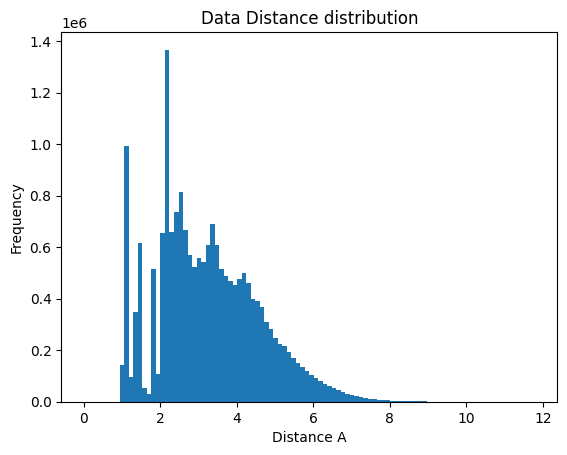

max distance: 11.7854
min distance: 0.0032
mean distance: 3.2446689698219227
std distance: 1.345138839090512


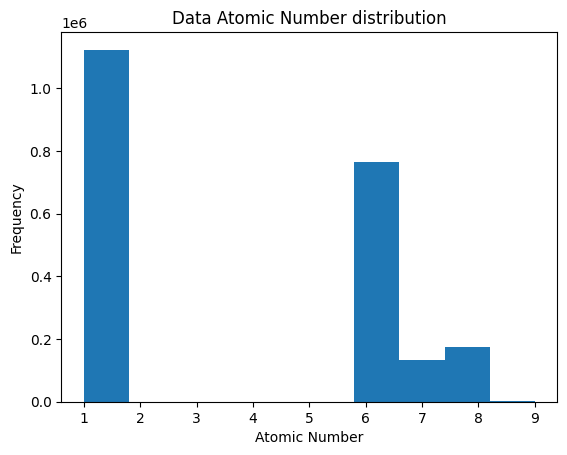

atoms types: [1 6 7 8 9]
atoms count: [1122550  764746  131950  174014    3305]


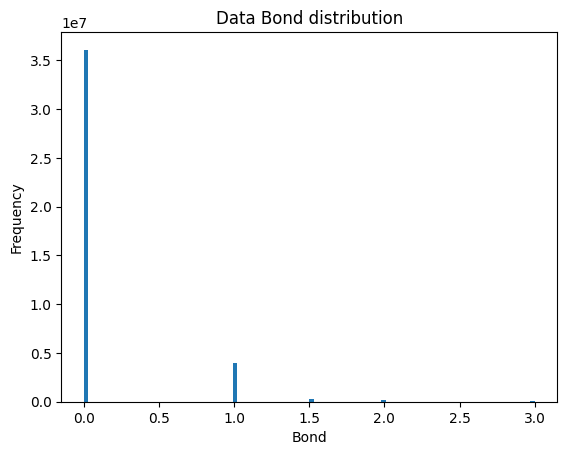

bond types: [0.  1.  1.5 2.  3. ]
bond count: [36085085  3993836   261174   181540    70952]


In [ ]:
import bz2
import pickle
import numpy as np
import matplotlib.pyplot as plt

with bz2.BZ2File('/content/drive/MyDrive/bond_test_data.pbz2', 'rb') as f:
  data = pickle.load(f)

all_distance = []
distance = data['Distance Matrices']
for matrix in distance:
  distance = matrix[np.triu_indices(len(matrix), k=1)]
  all_distance.extend(distance)
plt.hist(all_distance, bins=100)
plt.xlabel('Distance A')
plt.ylabel('Frequency')
plt.title('Data Distance distribution')
plt.show()

print(f'max distance: {max(all_distance)}')
print(f'min distance: {min(all_distance)}')
print(f'mean distance: {np.mean(all_distance)}')
print(f'std distance: {np.std(all_distance)}')

all_atoms = []
for atom in data['Atomic Numbers']:
  all_atoms.extend(atom)

atom_types, count = np.unique(all_atoms, return_counts=True)

plt.hist(all_atoms)
plt.xlabel('Atomic Number')
plt.ylabel('Frequency')
plt.title('Data Atomic Number distribution')
plt.show()

print(f'atoms types: {atom_types}')
print(f'atoms count: {count}')

all_bonds = []

for bond_matrix in data['Bond Matrices']:
  for bond in bond_matrix:
    all_bonds.extend(bond)

bond_types, count = np.unique(all_bonds, return_counts=True)

plt.hist(all_bonds, bins=100)
plt.xlabel('Bond')
plt.ylabel('Frequency')
plt.title('Data Bond distribution')
plt.show()

print(f'bond types: {bond_types}')
print(f'bond count: {count}')

In [ ]:
import bz2
import pickle
import numpy as np

with bz2.BZ2File('/content/drive/MyDrive/bond_test_data.pbz2', 'rb') as f:
  data = pickle.load(f)

def padding_atoms(x):
  map = {1:1, 6:2, 7:3, 8:4, 9:5}
  x = np.array(x)
  for i in range(len(x)):
    x[i] = map[x[i]]
  return np.pad(x, (0,29-len(x)), 'constant')

def padding_bonds(x):
  map = {0:0, 1:1, 1.5:2, 2:3, 3:4}
  x = np.array(x)
  np.pad(x, [(0,29-len(x)), (0,29-len(x))], 'constant')
  one_hot_bond = np.zeros((29, 29, 5))
  for i in range(len(x)):
    for j in range(len(x[i])):
      bond = x[i,j]
      oh_bond = map[bond]
      one_hot_bond[i,j,oh_bond] = 1


  return one_hot_bond

def padding_distance(x):
  x = np.array(x)
  return np.pad(x, [(0,29-len(x)), (0,29-len(x))], 'constant', constant_values=-1)

data['Pad Atoms'] = data['Atomic Numbers'].apply(padding_atoms)
data['Pad Bonds'] = data['Bond Matrices'].apply(padding_bonds)
data['Pad Distance'] = data['Distance Matrices'].apply(padding_distance)

data = data.drop(['Atomic Numbers', 'Bond Matrices', 'Distance Matrices'], axis=1)

with bz2.BZ2File('/content/drive/MyDrive/bond_test_data_padded.pbz2', 'wb') as f:
  pickle.dump(data, f)

In [ ]:
import bz2
import pickle
import numpy as np

with bz2.BZ2File('/content/drive/MyDrive/bond_test_data_padded.pbz2', 'rb') as f:
  data = pickle.load(f)

atoms = np.array(data['Pad Atoms'].to_list())
bonds = np.array(data['Pad Bonds'].to_list())
distance = np.array(data['Pad Distance'].to_list())


padded_categorical_weight = np.array([1.05, 25.73, 393.55, 566.22, 1448.77])



#Bond task running

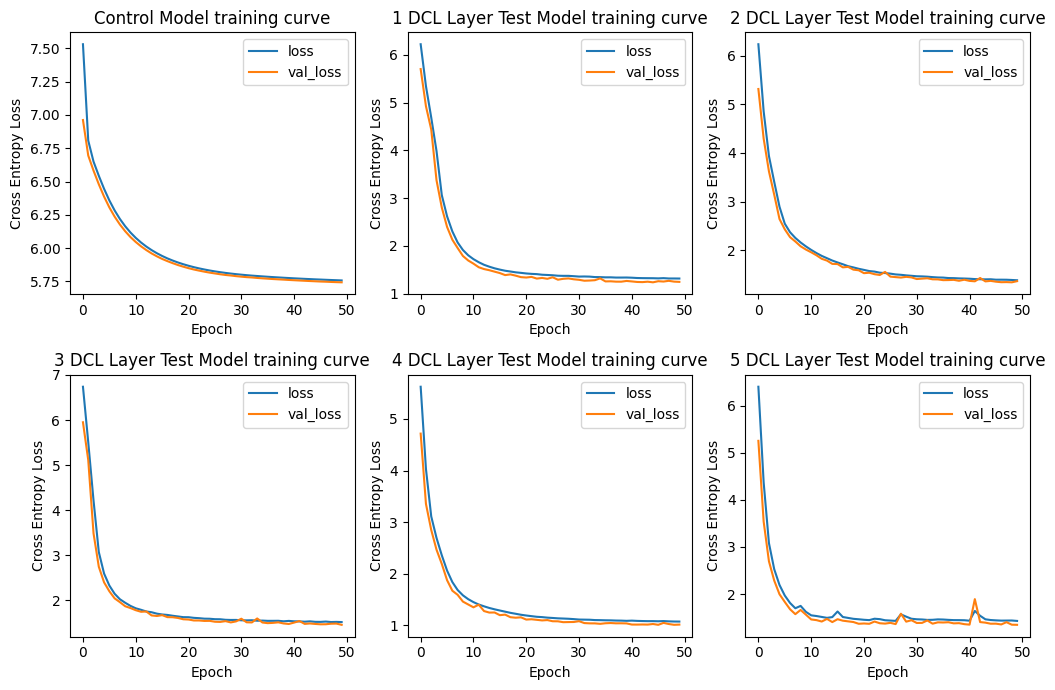

382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


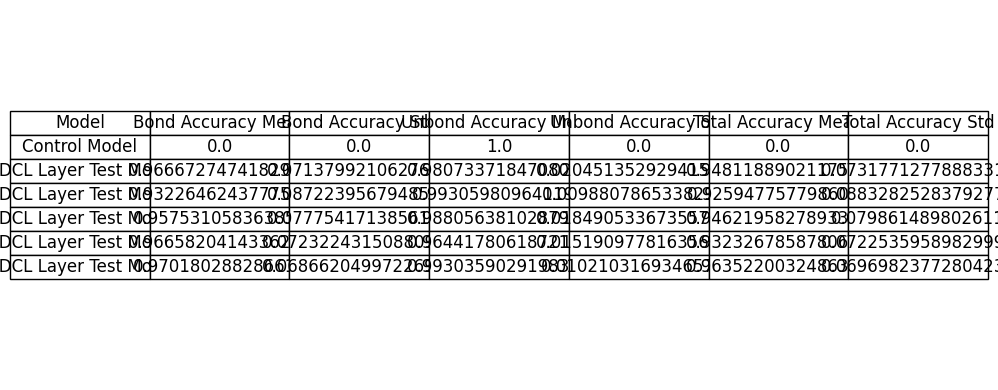

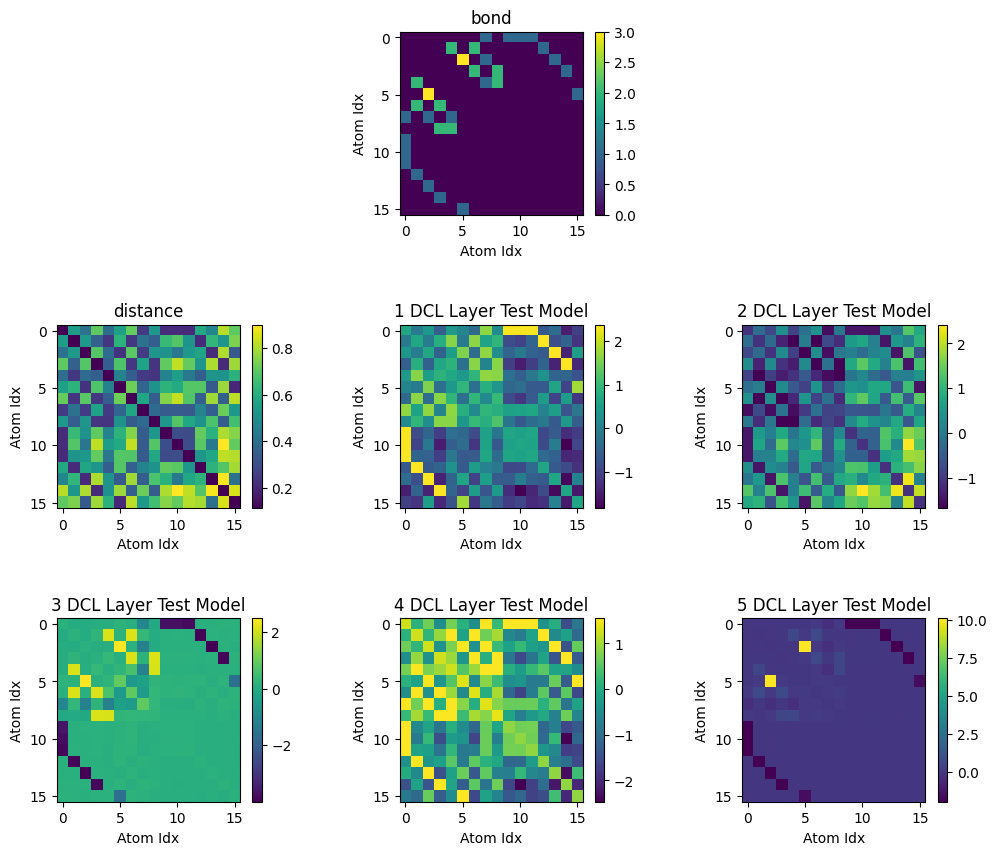

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

control_model = ControlModel()
dcl_1 = DCLTestModel(atom_types=5, num_heads=5, depth=8, layers=1)
dcl_2 = DCLTestModel(atom_types=5, num_heads=5, depth=8, layers=2)
dcl_3 = DCLTestModel(atom_types=5, num_heads=5, depth=8, layers=3)
dcl_4 = DCLTestModel(atom_types=5, num_heads=5, depth=8, layers=4)
dcl_5 = DCLTestModel(atom_types=5, num_heads=5, depth=8, layers=5)

models = [control_model, dcl_1, dcl_2, dcl_3, dcl_4, dcl_5]
model_names = ['Control Model', '1 DCL Layer Test Model', '2 DCL Layer Test Model', '3 DCL Layer Test Model', '4 DCL Layer Test Model', '5 DCL Layer Test Model']
control_models = [True, False, False, False, False, False]

models_evaluation(models, atoms, distance, bonds, batch_size=128, bond_weights=padded_categorical_weight, epochs=50, model_names=model_names, control_models=control_models)

# Energy task model

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

class GCNModel(tf.keras.Model):
  def __init__(self, atom_types, features, **kwargs):
    super().__init__(**kwargs)
    self.embedding = tf.keras.layers.Embedding(atom_types+1, features, name='atom_embedding', embeddings_initializer='random_normal', trainable=False)
    self.gcn = GraphConvolutionLayer(activation='relu')
    self.dense = tf.keras.layers.Dense(1,use_bias=False)

  def normalize_matrix(self, matrix, epsilon=1e-6):
    mean = tf.reduce_mean(matrix, axis=(0, 1), keepdims=True)
    std = tf.math.reduce_std(matrix, axis=(0, 1), keepdims=True)
    return (matrix - mean) / (std + epsilon)

  def call(self, inputs):
    atoms, bonds = inputs

    mask = tf.not_equal(atoms, 0)
    mask = tf.cast(mask, tf.float32)
    mask = tf.expand_dims(mask, axis=-1)


    bonds_shape = tf.shape(bonds)
    eye = tf.eye(bonds_shape[-1], bonds_shape[-2], bonds_shape[:-2], dtype=tf.float32)

    bonds += eye

    bonds = self.normalize_matrix(bonds)
    bonds = tf.nn.sigmoid(bonds)

    atom_features = self.embedding(atoms)

    atom_features = self.gcn([atom_features, bonds])

    energy = self.dense(atom_features)
    energy *= mask

    return tf.reduce_sum(energy, axis=[1,2])


class DCLGCNModel(tf.keras.Model):
  def __init__(self, atom_types, num_heads, depth, **kwargs):
    super().__init__(**kwargs)
    self.embedding = tf.keras.layers.Embedding(atom_types+1, num_heads*depth, name='atom_embedding', embeddings_initializer='random_normal', trainable=False)
    self.dcl = DynamicConnectionLayer(num_heads=num_heads, depth=depth, temperature=1.0)
    self.gcn = GraphConvolutionLayer(activation='relu')
    self.dense = tf.keras.layers.Dense(1, use_bias=False)

  def normalize_matrix(self, matrix, epsilon=1e-6):
    mean = tf.reduce_mean(matrix, axis=(0, 1), keepdims=True)
    std = tf.math.reduce_std(matrix, axis=(0, 1), keepdims=True)
    return (matrix - mean) / (std + epsilon)

  def call(self, inputs):
    atoms, bonds = inputs

    mask = tf.not_equal(atoms, 0)
    mask = tf.cast(mask, tf.float32)
    mask = tf.expand_dims(mask, axis=-1)

    atomic_feature = self.embedding(atoms)
    updated_bonds = self.dcl([atomic_feature, bonds])
    # updated_bonds = tf.nn.sigmoid(updated_bonds)
    updated_bonds = self.normalize_matrix(updated_bonds)
    updated_bonds = tf.nn.sigmoid(updated_bonds)
    atomic_feature = self.gcn([atomic_feature, updated_bonds])

    energy = self.dense(atomic_feature)
    energy *= mask
    return tf.reduce_sum(energy, axis=[1,2])

  def get_update_connection(self, inputs):
    atoms, bonds = inputs
    mask = tf.not_equal(atoms, 0)
    mask = tf.cast(mask, tf.float32)
    mask = tf.expand_dims(mask, axis=-1)

    atomic_feature = self.embedding(atoms)
    updated_bonds = self.dcl([atomic_feature, bonds])

    return updated_bonds


def model_evaluation(dcl_model, control_model, atoms, bonds, energies, batch_size):
  train_atoms, test_atoms, train_bonds, test_bonds, train_energies, test_energies = train_test_split(atoms, bonds, energies, test_size=0.1)


  dcl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss=tf.keras.losses.MeanSquaredError())
  control_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss=tf.keras.losses.MeanSquaredError())

  np.random.seed(47)

  random_idx = np.random.randint(4, len(test_atoms))

  v_z, v_b, = test_atoms[random_idx-4:random_idx], test_bonds[random_idx-4:random_idx]


  z = np.not_equal(v_z, 0)
  z = np.sum(z, axis=-1)
  z = list(z)

  dcl_history = dcl_model.fit(x=[train_atoms, train_bonds], y=train_energies, batch_size=batch_size, epochs=250,
                              validation_data=([test_atoms, test_bonds], test_energies), verbose=1,
                              callbacks=[tf.keras.callbacks.CSVLogger(f'/content/drive/MyDrive/dclgcn')])

  control_history = control_model.fit(x=[train_atoms, train_bonds], y=train_energies, batch_size=batch_size, epochs=250,
                                      validation_data=([test_atoms, test_bonds], test_energies), verbose=1,
                                      callbacks=[tf.keras.callbacks.CSVLogger(f'/content/drive/MyDrive/gcn')])

  updated_bonds = dcl_model.get_update_connection([v_z, v_b])


  fig, axes = plt.subplots(2 , 2, figsize=(10, 8))

  axes[0][0].plot(dcl_history.history['loss'], label='loss')
  axes[0][0].plot(dcl_history.history['val_loss'], label='val_loss')
  axes[0][0].set_title(f'DCL Model Training curve')
  axes[0][0].set_xlabel('Epoch')
  axes[0][0].set_ylabel('MES Loss')
  axes[0][0].legend()

  x_axis = range(50,250)

  axes[1][0].plot(x_axis,dcl_history.history['loss'][50:], label='loss')
  axes[1][0].plot(x_axis,dcl_history.history['val_loss'][50:], label='val_loss')
  axes[1][0].set_title(f'DCL Model after 50 epoch')
  axes[1][0].set_xlabel('Epoch')
  axes[1][0].set_ylabel('MES Loss')
  axes[1][0].legend()

  axes[0][1].plot(control_history.history['loss'], label='loss')
  axes[0][1].plot(control_history.history['val_loss'], label='val_loss')
  axes[0][1].set_title(f'Control Model Training curve')
  axes[0][1].set_xlabel('Epoch')
  axes[0][1].set_ylabel('MES Loss')
  axes[0][1].legend()

  axes[1][1].plot(x_axis,control_history.history['loss'][50:], label='loss')
  axes[1][1].plot(x_axis,control_history.history['val_loss'][50:], label='val_loss')
  axes[1][1].set_title(f'Control Model after 50 epoch')
  axes[1][1].set_xlabel('Epoch')
  axes[1][1].set_ylabel('MES Loss')
  axes[1][1].legend()

  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
  plt.savefig(f'/content/drive/MyDrive/energy_traing.png', dpi=600)
  plt.show()

  def normalize_matrix(matrix, epsilon=1e-6):
    mean = np.mean(matrix, axis=(0, 1), keepdims=True)
    std = np.std(matrix, axis=(0, 1), keepdims=True)
    return (matrix - mean) / (std + epsilon)

  fig, axes = plt.subplots(3, 4, figsize=(20, 12))

  for i in range(4):
    atoms = z[i]
    org_bond = v_b[i]
    updated_bond = updated_bonds[i]

    sigmoid_bond = tf.nn.sigmoid(updated_bond)

    normalized_bond = normalize_matrix(updated_bond)


    ticks = np.arange(atoms)

    im1 = axes[0][i].imshow(org_bond[:atoms, :atoms],cmap='viridis', aspect='auto')
    axes[0][i].set_title(f'Original Bond {i+1}')
    fig.colorbar(im1, ax=axes[0][i])

    im2 = axes[1][i].imshow(normalized_bond[:atoms, :atoms],cmap='viridis', aspect='auto')
    axes[1][i].set_title(f'Normal updated Bond {i+1}')
    fig.colorbar(im2, ax=axes[1][i])

    im3 = axes[2][i].imshow(sigmoid_bond[:atoms, :atoms],cmap='viridis', aspect='auto')
    axes[2][i].set_title(f'Sigmoid Bond {i+1}')
    fig.colorbar(im3, ax=axes[2][i])


  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

  plt.savefig(f'/content/drive/MyDrive/update_bonds.png', dpi=600)

  plt.show()








##Energy Data(bond)

In [ ]:
import bz2
import pickle
import numpy as np

with bz2.BZ2File('/content/drive/MyDrive/energy_test_bond_data.pbz2', 'rb') as f:
  data = pickle.load(f)

atom_map = {0:0, 1:1, 6:2, 7:3, 8:4, 9:5}
atoms = np.array(data['Pad Atoms'].to_list())
bonds = np.array(data['Pad Bond'].to_list())
energy = np.array(data['Gibbs Energy'].to_list())

tensor_mapping = np.vectorize(atom_map.get)
atoms = tensor_mapping(atoms)


#Energy task running (bond)

Epoch 1/250
860/860 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 163873.4688 - val_loss: 125083.2812
Epoch 2/250
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 108336.7891 - val_loss: 58554.0352
Epoch 3/250
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 46693.1016 - val_loss: 21920.3984
Epoch 4/250
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 19031.1172 - val_loss: 13522.5801
Epoch 5/250
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12569.0176 - val_loss: 8313.2275
Epoch 6/250
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7250.5605 - val_loss: 4539.5781
Epoch 7/250
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3988.9631 - val_loss: 2538.0312
Epoch 8/250
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2295.5750 - val_loss: 1717.0450
Epoch 9/250
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1652.0266 - val_loss: 1416.6492
Epoch 10/250
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1375.5461 - val_loss: 1229.9152
Epoch 11/250
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - 

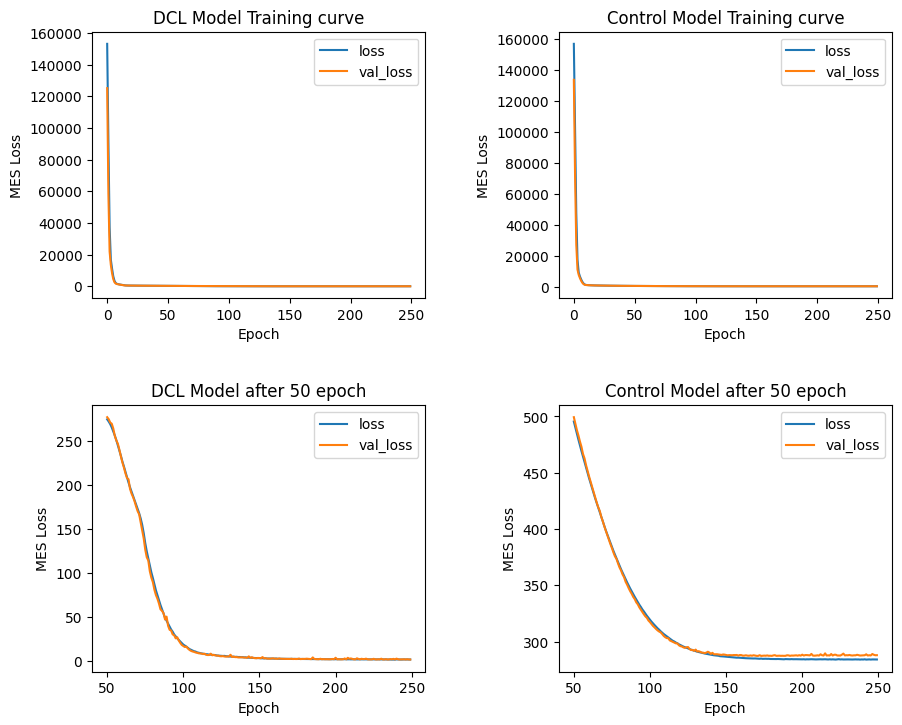

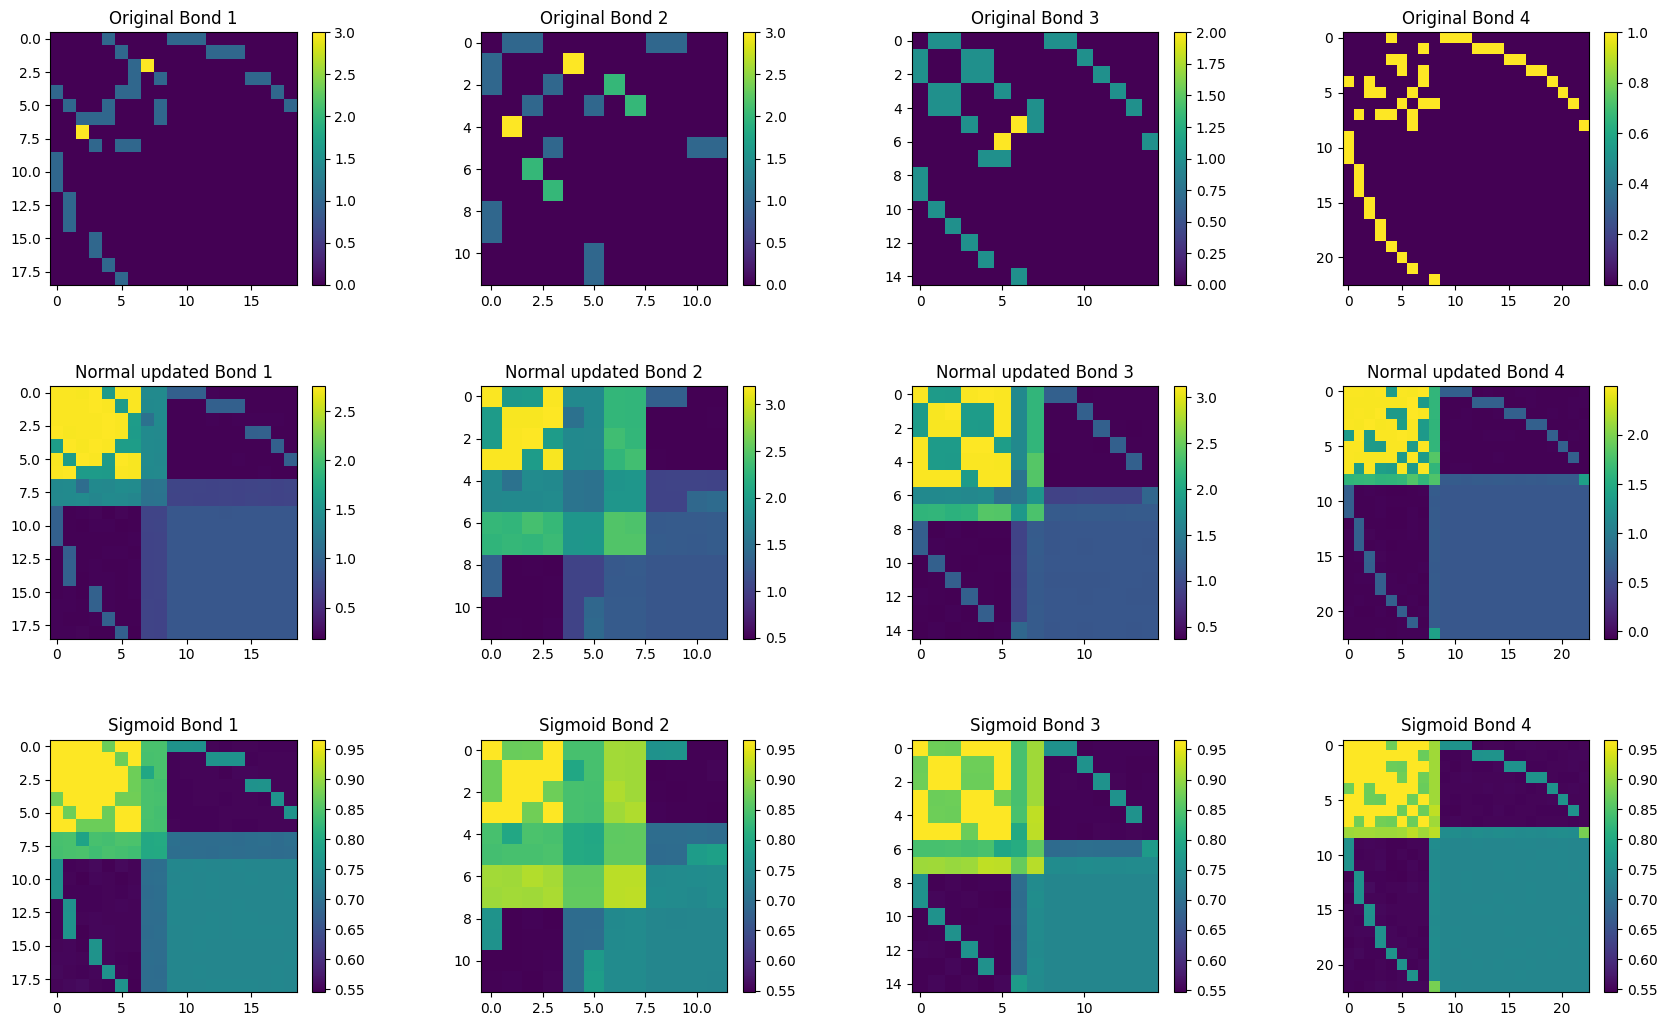

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

dcl_model = DCLGCNModel(atom_types=5, num_heads=5, depth=8)
control_model = GCNModel(atom_types=5, features=40)

model_evaluation(dcl_model, control_model, atoms, bonds, energy, batch_size=128)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

class GCNModel(tf.keras.Model):
  def __init__(self, atom_types, features, **kwargs):
    super().__init__(**kwargs)
    self.embedding = tf.keras.layers.Embedding(atom_types+1, features, name='atom_embedding', embeddings_initializer='random_normal', trainable=False)
    self.gcn = GraphConvolutionLayer(activation='relu')
    self.dense = tf.keras.layers.Dense(1,use_bias=False)

  def normalize_matrix(self, matrix, epsilon=1e-6):
    mean = tf.reduce_mean(matrix, axis=(0, 1), keepdims=True)
    std = tf.math.reduce_std(matrix, axis=(0, 1), keepdims=True)
    return (matrix - mean) / (std + epsilon)

  def call(self, inputs):
    atoms, bonds = inputs

    mask = tf.not_equal(atoms, 0)
    mask = tf.cast(mask, tf.float32)
    mask = tf.expand_dims(mask, axis=-1)


    bonds_shape = tf.shape(bonds)
    eye = tf.eye(bonds_shape[-1], bonds_shape[-2], bonds_shape[:-2], dtype=tf.float32)

    bonds += eye

    # bonds = self.normalize_matrix(bonds)
    # bonds = tf.nn.sigmoid(bonds)

    atom_features = self.embedding(atoms)

    atom_features = self.gcn([atom_features, bonds])

    energy = self.dense(atom_features)
    energy *= mask

    return tf.reduce_sum(energy, axis=[1,2])

def model_evaluation(control_model, atoms, bonds, energies, batch_size):
  train_atoms, test_atoms, train_bonds, test_bonds, train_energies, test_energies = train_test_split(atoms, bonds, energies, test_size=0.1)

  control_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss=tf.keras.losses.MeanSquaredError())

  control_history = control_model.fit(x=[train_atoms, train_bonds], y=train_energies, batch_size=batch_size, epochs=150,
                                      validation_data=([test_atoms, test_bonds], test_energies), verbose=1,
                                      callbacks=[tf.keras.callbacks.CSVLogger(f'/content/drive/MyDrive/gcn_raw')])

  fig, axes = plt.subplots(1 , 2, figsize=(10, 4))

  axes[0].plot(control_history.history['loss'], label='loss')
  axes[0].plot(control_history.history['val_loss'], label='val_loss')
  axes[0].set_title(f'Control Model Training curve (raw)')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('MES Loss')
  axes[0].legend()

  x_axis = range(50,150)

  axes[1].plot(x_axis,control_history.history['loss'][50:], label='loss')
  axes[1].plot(x_axis,control_history.history['val_loss'][50:], label='val_loss')
  axes[1].set_title(f'Control Model after 50 epoch (raw)')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('MES Loss')
  axes[1].legend()

  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
  plt.savefig(f'/content/drive/MyDrive/energy_traing_raw.png', dpi=600)
  plt.show()








